In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import calculate_eddy, dopioe, espra_Rc, plot_ellipse, solve_w, calc_ow, normalize_matrix
from utils import dopioe_grid, moca, espra, extract_transect_center, gaussian_vel_reconstruction

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150,150,:]

the_frontier_eddies

['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']

In [2]:
dic = sample_data['Eddy775']['T0']
dic.keys()

dict_keys(['U', 'V', 'x', 'y', 'z', 'VG', 'COW', 'LNAM', 'rho'])

In [3]:
U, V, x, y, z = dic['U'], dic['V'], dic['x']/1000, dic['y']/1000, -dic['z']/1000
X, Y = np.meshgrid(x, y)
X, Y = X.T, Y.T

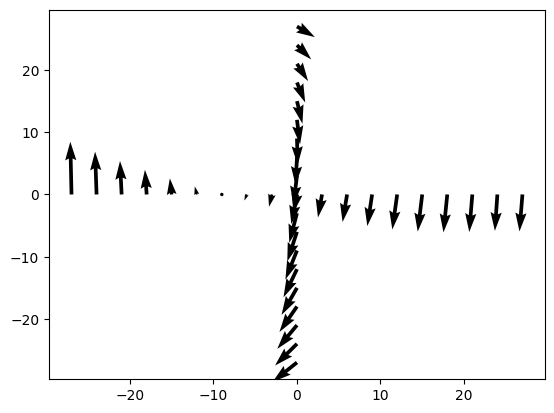

In [4]:
k = 0
u, v = U[:,:,k], V[:,:,k]
dic = extract_transect_center(u, v, X, Y, 0, 0, r=30)

x1 = dic['x1']
y1 = dic['y1']
u1 = dic['u1']
v1 = dic['v1']
xx = dic['xx']
x2 = dic['x2']
y2 = dic['y2']
u2 = dic['u2']
v2 = dic['v2']
yy = dic['yy']

plt.quiver(x1, y1, u1, v1)
plt.quiver(x2, y2, u2, v2)


MOCA 3.2298087852391393 11.067891242800982
DOPIOE 3.4945292889560826 11.88025440933978
ESPRA 3.201663580128539 12.215337540416627


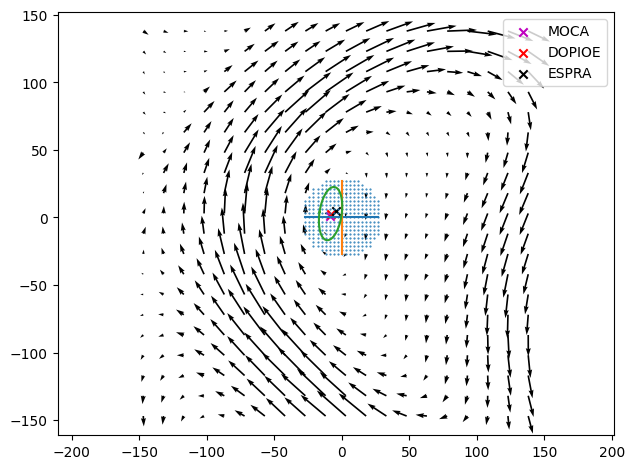

In [5]:
k = 0
spacing = 5
plt.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)

# nic, njc = len(x)//2, len(y)//2
nic, njc = 49, 49
r = 30

plt.plot(x1, y1)
plt.plot(x2, y2)

# MOCA
l = x1 - x1.min()
VT, VN = u1, v1
l0, r0, wmoca, Qmoca, Rcmoca, psi0moca = moca(l, VT, VN)
x0moca, y0moca = x1.min() + l0, y1[0] + r0
print('MOCA', Rcmoca, psi0moca)
plt.scatter(x0moca, y0moca, marker='x', color='m', label='MOCA')

# DOPIOE
x0, y0, w, Q, Rc_opt, psi0_opt = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
print('DOPIOE', Rc_opt, psi0_opt)
plt.scatter(x0, y0, marker='x', color='r', label='DOPIOE')

x_ell, y_ell = plot_ellipse(Q, center=(x0, y0), scale=20)
plt.plot(x_ell, y_ell)

# ESPRA
mask = (np.hypot(X - x[nic], Y - y[njc]) < r)
xi, yi = X[mask], Y[mask]
ui, vi = u[mask], v[mask]
x0esp, y0esp, wesp, Qesp, Rc_optesp, psi0_optesp = espra(xi, yi, ui, vi)
print('ESPRA', Rc_optesp, psi0_optesp)
plt.scatter(x0esp, y0esp, marker='x', color='k', label='ESPRA')
plt.scatter(xi, yi, marker='.', s=1)

plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()


#### Paper Plot

In [6]:
df_plot = pd.DataFrame({ 'Eddy': [the_frontier_eddies[0]]*3 + [the_frontier_eddies[1]]*3 
                               + [the_frontier_eddies[2]]*3 + [the_frontier_eddies[3]]*3,
                          'Day': [0, 23, 28,   0, 7, 25,    0, 19, 24,    1, 5, 14],
                            'z': [0, 6, 3,     0, 0, 9,     0, 6, 3,      3, 3,  6]})


In [7]:
df_data = pd.DataFrame(columns=['Eddy', 'Day', 'Method', 'xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'z', 'Depth'])

Rc_upper_bound = np.inf
psi0_abs_bound = np.inf # 500

for p in range(len(df_plot)):

    eddy, day, k = df_plot.iloc[p].Eddy, df_plot.iloc[p].Day, df_plot.iloc[p].z
    day = f'T{day}'
    
    dic_eddy = sample_data[eddy]

    dic = dic_eddy[day]

    U, V, x, y, z = dic['U'], dic['V'], dic['x']/1000, dic['y']/1000, -dic['z']/1000
    X, Y = np.meshgrid(x, y)
    X, Y = X.T, Y.T
    r = 30

    x0old, y0old = -12, -12
    moca_flag = 1
    dopioe_flag = 1

    u, v = U[:,:,k], V[:,:,k]
    dic = extract_transect_center(u, v, X, Y, x0old, y0old, r)
    
    x1, y1, u1, v1, xx = dic['x1'], dic['y1'], dic['u1'], dic['v1'], dic['xx']
    x2, y2, u2, v2, yy = dic['x2'], dic['y2'], dic['u2'], dic['v2'], dic['yy']
    
    # MOCA
    if moca_flag:
        l = x1 - x1.min()
        VT, VN = u1, v1
        l0, r0, wmoca, Qmoca, Rcmoca, psi0moca = moca(l, VT, VN, Rc_upper_bound=Rc_upper_bound, psi0_abs_bound=psi0_abs_bound)
        x0moca, y0moca = x1.min() + l0, y1[0] + r0
        if not np.isnan(x0moca):

            # if np.hypot(x0moca - x0old, y0moca - y0old) < 50:
            
            df_data.loc[len(df_data)] = {
                'Eddy': eddy, 'Day': int(day[1:]), 'Method': 'MOCA',
                'xc': x0moca, 'yc': y0moca, 'w': wmoca,
                'Q': Qmoca, 'Rc': Rcmoca, 'psi0': psi0moca,
                'z': k, 'Depth': -z_r[k]
                }
        #     else:
        #         moca_flag = 0
        # else:
        #     moca_flag = 0
    
    # DOPIOE
    if dopioe_flag:
        x0dop, y0dop, wdop, Qdop, Rcdop, psi0dop = dopioe(x1, y1, u1, v1, x2, y2, u2, v2, Rc_upper_bound=Rc_upper_bound, psi0_abs_bound=psi0_abs_bound)
        if not np.isnan(x0dop):

            # if np.hypot(x0dop - x0old, y0dop - y0old) < 50:
                
            df_data.loc[len(df_data)] = {
                'Eddy': eddy, 'Day': int(day[1:]), 'Method': 'DOPIOE',
                'xc': x0dop, 'yc': y0dop, 'w': wdop,
                'Q': Qdop, 'Rc': Rcdop, 'psi0': psi0dop,
                'z': k, 'Depth': -z_r[k]
                }
        #     else:
        #         dopioe_flag = 0
        # else:
        #     dopioe_flag = 0
    
    # ESPRA
    mask = (np.hypot(X - x0old, Y - y0old) < r)
    xi, yi = X[mask], Y[mask]
    ui, vi = u[mask], v[mask]
    x0esp, y0esp, wesp, Qesp, Rcesp, psi0esp = espra(xi, yi, ui, vi, Rc_upper_bound=Rc_upper_bound, psi0_abs_bound=psi0_abs_bound)
    if not np.isnan(x0esp):

        # if np.hypot(x0esp - x0old, y0esp - y0old) < 50:
        
        df_data.loc[len(df_data)] = {
            'Eddy': eddy, 'Day': int(day[1:]), 'Method': 'ESPRA',
            'xc': x0esp, 'yc': y0esp, 'w': wesp,
            'Q': Qesp, 'Rc': Rcesp, 'psi0': psi0esp,
            'z': k, 'Depth': -z_r[k]
            }
        # x0old, y0old = x0esp, y0esp
    #     else:
    #         break
    # else:
    #     break


3.9912492461095472 -15.120695144226088
3.9912492461095472 -15.120695144226088
4.749839633596979 -21.724932594238275


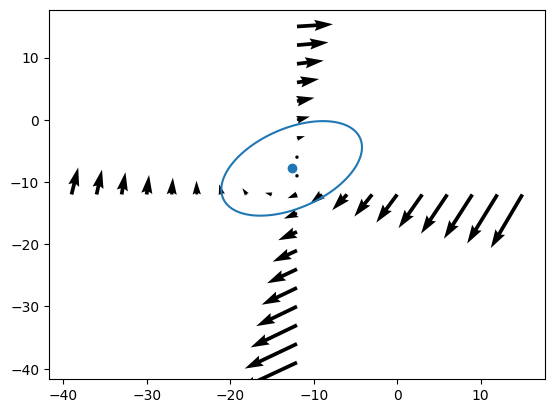

In [8]:
plt.quiver(x1, y1, u1, v1)
plt.quiver(x2, y2, u2, v2)

points1 = set(zip(x1, y1))
points2 = set(zip(x2, y2))
common_points = points1 & points2

# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]
y1f = y1[mask]
u1f = u1[mask]
v1f = v1[mask]

xi = np.concatenate([x1f, x2])
yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2])
vi = np.concatenate([v1f, v2])

# xi = np.concatenate([x1, x2])
# yi = np.concatenate([y1, y2])
# ui = np.concatenate([u1, u2])
# vi = np.concatenate([v1, v2])

x0, y0, w, Q, Rc_opt, psi0_opt  = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
print(Rc_opt, psi0_opt) #wrong
plt.scatter(x0, y0)
x_ell, y_ell = plot_ellipse(Q, (x0,y0), scale=10)
plt.plot(x_ell, y_ell)

Rc_opt, psi0_opt = espra_Rc(xi, yi, ui, vi, x0, y0, Q[0,0], Q[0,1], Q[1,1])
print(Rc_opt, psi0_opt)


x0, y0, w, Q, Rc_opt, psi0_opt = espra(xi, yi, ui, vi)
print(Rc_opt, psi0_opt)


In [9]:
def int_to_excel(n):
    # Convert 0-indexed integer n to an Excel-style column label in lowercase
    n += 1  # Convert to 1-indexed
    result = ""
    while n:
        n, remainder = divmod(n - 1, 26)
        result = chr(97 + remainder) + result  # 97 is ASCII for 'a'
    return result
    

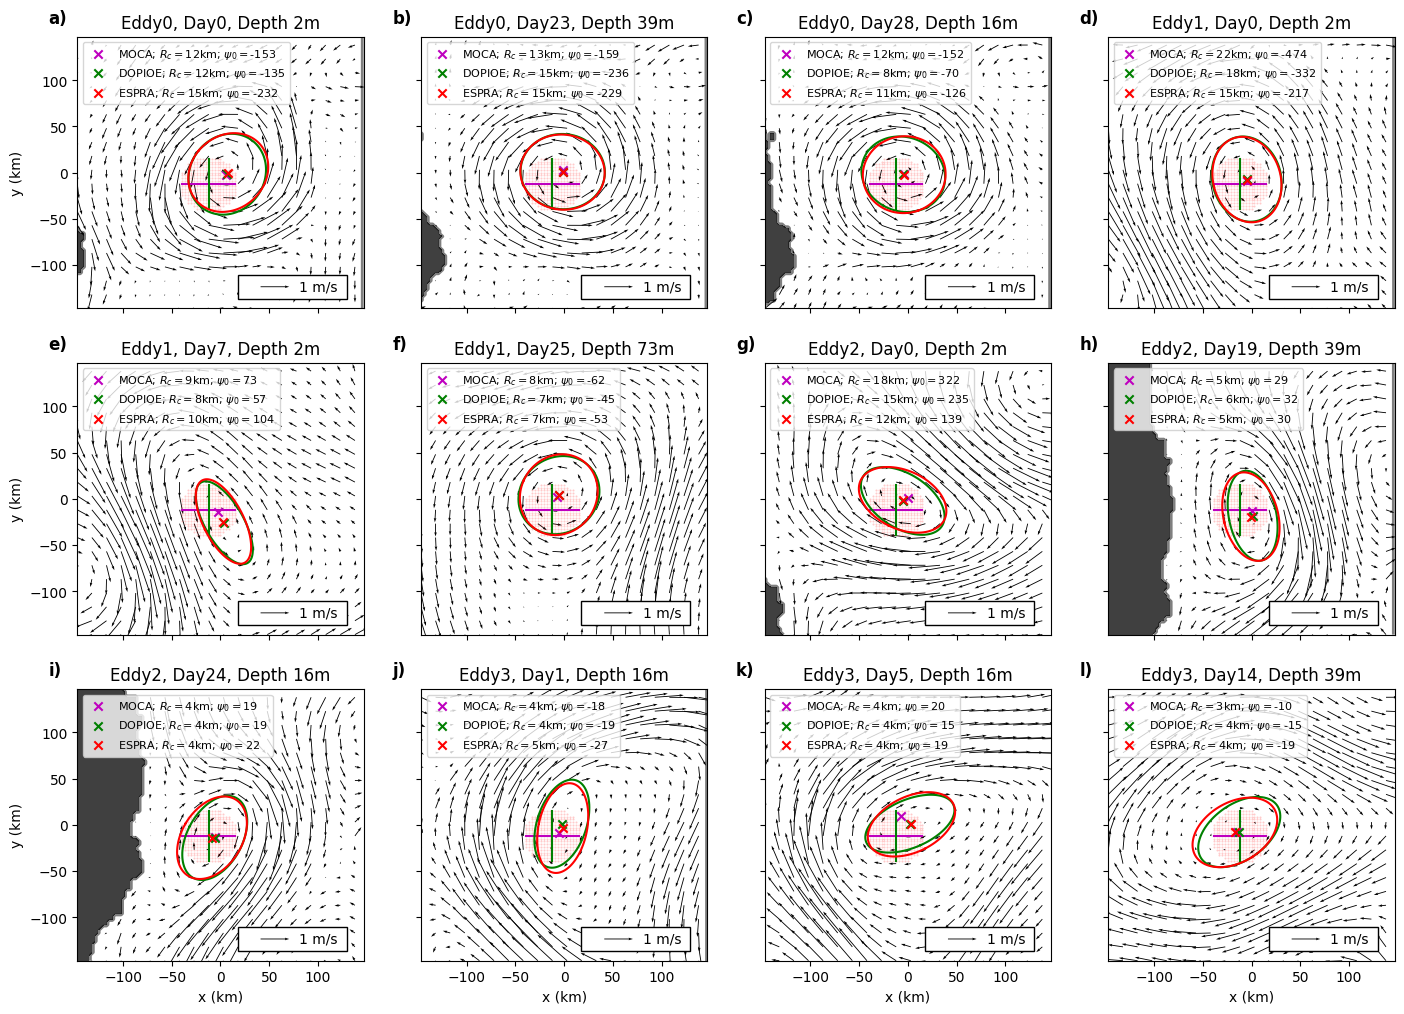

In [10]:
from matplotlib.patches import Rectangle
rows, cols = 3, 4

fig, axs = plt.subplots(rows, cols, figsize=(17, 12), sharey=True, sharex=True)
quiv_scale = 10
for p in range(len(df_plot)):

    ax = axs[p // cols, p % cols]

    eddy, day, k = df_plot.iloc[p].Eddy, df_plot.iloc[p].Day, df_plot.iloc[p].z

    moca_data = df_data[(df_data['Eddy']==eddy)&(df_data['Method']=='MOCA')&(df_data['Day']==day)&(df_data['z']==k)].iloc[0]
    dopioe_data = df_data[(df_data['Eddy']==eddy)&(df_data['Method']=='DOPIOE')&(df_data['Day']==day)&(df_data['z']==k)].iloc[0]
    espra_data = df_data[(df_data['Eddy']==eddy)&(df_data['Method']=='ESPRA')&(df_data['Day']==day)&(df_data['z']==k)].iloc[0]

    dic = sample_data[eddy][f'T{day}']
    U, V, x, y, z = dic['U'], dic['V'], dic['x']/1000, dic['y']/1000, -dic['z']/1000
    u, v = U[:,:,k], V[:,:,k]
    X, Y = np.meshgrid(x, y)
    X, Y = X.T, Y.T

    r = 30
    dic = extract_transect_center(u, v, X, Y, x0old, y0old, r)
    x1, y1, x2, y2 = dic['x1'], dic['y1'], dic['x2'], dic['y2']
    mask = (np.hypot(X - x0old, Y - y0old) < r)
    xi, yi = X[mask], Y[mask]

    spacing = 5
    quiv = ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
              u[::spacing, ::spacing], v[::spacing, ::spacing], scale=quiv_scale)

    ax.scatter(moca_data.xc, moca_data.yc, marker='x', color='m', zorder=5, label=fr'MOCA; $R_c=${round(moca_data.Rc)}km; $\psi_0=${round(moca_data.psi0)}')
    ax.scatter(dopioe_data.xc, dopioe_data.yc, marker='x', color='g', zorder=6, label=fr'DOPIOE; $R_c=${round(dopioe_data.Rc)}km; $\psi_0=${round(dopioe_data.psi0)}')
    ax.scatter(espra_data.xc, espra_data.yc, marker='x', color='r', zorder=7, label=fr'ESPRA; $R_c=${round(espra_data.Rc)}km; $\psi_0=${round(espra_data.psi0)}')
    ax.legend(loc='upper left', fontsize=8)

    ax.plot(x1, y1, color='m')
    ax.plot(x2, y2, color='g')
    ax.scatter(xi, yi, marker='.', s=1, color='r', alpha=.2)

    x_elldop, y_elldop = plot_ellipse(dopioe_data.Q, (dopioe_data.xc, dopioe_data.yc), 50)
    ax.plot(x_elldop, y_elldop, color='g')
    x_ellesp, y_ellesp = plot_ellipse(espra_data.Q, (espra_data.xc, espra_data.yc), 50)
    ax.plot(x_ellesp, y_ellesp, color='r')

    ax.set_title(f'Eddy{np.where(np.array(the_frontier_eddies)==eddy)[0][0]}, Day{day}, Depth {round(-z_r[k])}m')

    if np.any(np.isnan(u)):
        nan_mask = np.isnan(u)
        mask = np.where(~np.isnan(u), np.nan, 0)
        ax.contourf(X, Y, mask, cmap='gray', zorder=-1)
        ax.contour(X, Y, nan_mask, colors='k', linewidths=2, alpha=.5)

    if p // cols == rows - 1:
        ax.set_xlabel('x (km)')
    if p % cols == 0:
        ax.set_ylabel('y (km)')

    ax.text(-0.1, 1.05, int_to_excel(p)+')', transform=ax.transAxes, fontsize=12, fontweight='bold')

    magnitude = 1
    x_pos, y_pos = 0.75, 0.08  
    box_width = 0.38 # Adjust width as needed
    box_height = 0.09  # Adjust height as needed
    rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                           box_width, box_height, transform=ax.transAxes,
                           facecolor='white', edgecolor='black')
    ax.add_patch(rect)
    ax.quiverkey(quiv, X=x_pos-.01, Y=y_pos, U=magnitude,
                 label=f'{magnitude} m/s', labelpos='E')
    

#### Proper Method (Not fixed transects as they are above)

In [11]:
df_data1 = pd.DataFrame(columns=['Eddy', 'Day', 'Method', 'xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'z', 'Depth'])

Rc_upper_bound = np.inf
psi0_abs_bound = np.inf # 500

for p in range(len(df_plot)):

    eddy, day = df_plot.iloc[p].Eddy, df_plot.iloc[p].Day
    day = f'T{day}'
    
    dic_eddy = sample_data[eddy]

    dic = dic_eddy[day]

    U, V, x, y, z = dic['U'], dic['V'], dic['x']/1000, dic['y']/1000, -dic['z']/1000
    X, Y = np.meshgrid(x, y)
    X, Y = X.T, Y.T
    r = 50

    x0old_moc, y0old_moc = 0, 0
    x0old_dop, y0old_dop = 0, 0
    x0old_esp, y0old_esp = 0, 0

    
    moca_flag = 1
    dopioe_flag = 1
    esp_flag = 1

    for k in range(U.shape[-1]):
    
        u, v = U[:,:,k], V[:,:,k]
        dic_moc = extract_transect_center(u, v, X, Y, x0old_moc, y0old_moc, r)
        dic_dop = extract_transect_center(u, v, X, Y, x0old_dop, y0old_dop, r)
        
        x1_moc, y1_moc, u1_moc, v1_moc, xx_moc = dic_moc['x1'], dic_moc['y1'], dic_moc['u1'], dic_moc['v1'], dic_moc['xx']
    
        x1_dop, y1_dop, u1_dop, v1_dop, xx_dop = dic_dop['x1'], dic_dop['y1'], dic_dop['u1'], dic_dop['v1'], dic_dop['xx']
        x2_dop, y2_dop, u2_dop, v2_dop, yy_dop = dic_dop['x2'], dic_dop['y2'], dic_dop['u2'], dic_dop['v2'], dic_dop['yy']
        
        # MOCA
        if moca_flag:
            l = x1_moc - x1_moc.min()
            VT, VN = u1_moc, v1_moc
            l0, r0, wmoca, Qmoca, Rcmoca, psi0moca = moca(l, VT, VN, Rc_upper_bound=Rc_upper_bound, psi0_abs_bound=psi0_abs_bound)
            x0moca, y0moca = x1_moc.min() + l0, y1_moc[0] + r0
            if not np.isnan(x0moca):
    
                if np.hypot(x0moca - x0old_moc, y0moca - y0old_moc) < 50:
                
                    df_data1.loc[len(df_data1)] = {
                        'Eddy': eddy, 'Day': int(day[1:]), 'Method': 'MOCA',
                        'xc': x0moca, 'yc': y0moca, 'w': wmoca,
                        'Q': Qmoca, 'Rc': Rcmoca, 'psi0': psi0moca,
                        'z': k, 'Depth': -z_r[k]
                        }
                    x0old_moc, y0old_moc = x0moca, y0moca
                else:
                    moca_flag = 0
            else:
                moca_flag = 0
        
        # DOPIOE
        if dopioe_flag:
            x0dop, y0dop, wdop, Qdop, Rcdop, psi0dop = dopioe(x1_dop, y1_dop, u1_dop, v1_dop, x2_dop, y2_dop, u2_dop, v2_dop, Rc_upper_bound=Rc_upper_bound, psi0_abs_bound=psi0_abs_bound)
            if not np.isnan(x0dop):
    
                if np.hypot(x0dop - x0old_dop, y0dop - y0old_dop) < 50:
                    
                    df_data1.loc[len(df_data1)] = {
                        'Eddy': eddy, 'Day': int(day[1:]), 'Method': 'DOPIOE',
                        'xc': x0dop, 'yc': y0dop, 'w': wdop,
                        'Q': Qdop, 'Rc': Rcdop, 'psi0': psi0dop,
                        'z': k, 'Depth': -z_r[k]
                        }
                    x0old_dop, y0old_dop = x0dop, y0dop
                else:
                    dopioe_flag = 0
            else:
                dopioe_flag = 0
        
        # ESPRA
        if esp_flag:
            mask = (np.hypot(X - x0old_esp, Y - y0old_esp) < r)
            xi, yi = X[mask], Y[mask]
            ui, vi = u[mask], v[mask]
            x0esp, y0esp, wesp, Qesp, Rcesp, psi0esp = espra(xi, yi, ui, vi, Rc_upper_bound=Rc_upper_bound, psi0_abs_bound=psi0_abs_bound)
            if not np.isnan(x0esp):
        
                if np.hypot(x0esp - x0old_esp, y0esp - y0old_esp) < 50:
                
                    df_data1.loc[len(df_data1)] = {
                        'Eddy': eddy, 'Day': int(day[1:]), 'Method': 'ESPRA',
                        'xc': x0esp, 'yc': y0esp, 'w': wesp,
                        'Q': Qesp, 'Rc': Rcesp, 'psi0': psi0esp,
                        'z': k, 'Depth': -z_r[k]
                        }
                    x0old_esp, y0old_esp = x0esp, y0esp
                else:
                    esp_flag = 0
            else:
                esp_flag = 0

df_data1.to_pickle("/srv/scratch/z5297792/Chapter1/df_ESM_data.pkl")

In [12]:
df_data1

,Eddy,Day,Method,xc,yc,w,Q,Rc,psi0,z,Depth
0,Eddy790,0,MOCA,7.073857,-0.320018,0.040862,"[[0.01021553889105897, 0.0], [0.0, 0.010215538...",12.724221,-162.681615,0,1.783320
1,Eddy790,0,DOPIOE,6.978846,-0.998736,0.037260,"[[0.010215538891058966, -0.0009718163712696494...",12.352301,-153.567700,0,1.783320
2,Eddy790,0,ESPRA,6.908389,1.146804,0.033621,"[[0.009175594081254197, -0.0010552806033315128...",13.480621,-190.007127,0,1.783320
3,Eddy790,0,MOCA,6.200574,0.440724,0.041154,"[[0.010288600328302724, 0.0], [0.0, 0.01028860...",12.657973,-160.213307,1,5.879627
4,Eddy790,0,DOPIOE,6.288312,0.726667,0.037228,"[[0.010268912104250244, -0.0009866409949699693...",12.828645,-164.809556,1,5.879627
...,...,...,...,...,...,...,...,...,...,...,...
935,Eddy775,14,DOPIOE,-39.560099,81.566126,-0.005340,"[[-0.0019518818498227054, 0.000173456206651728...",2.820278,8.934720,27,3930.053268
936,Eddy775,14,ESPRA,-49.301837,71.666867,-0.004106,"[[-0.0013979663021190583, 8.20859769637287e-05...",5.596377,32.320368,27,3930.053268
937,Eddy775,14,MOCA,-40.944978,67.652139,-0.007675,"[[-0.0019187602359296836, 0.0], [0.0, -0.00191...",3.722712,14.234034,28,4460.447022
938,Eddy775,14,DOPIOE,-39.347450,82.958637,-0.005611,"[[-0.002087823516150796, 8.337124287287109e-05...",3.271787,12.005593,28,4460.447022


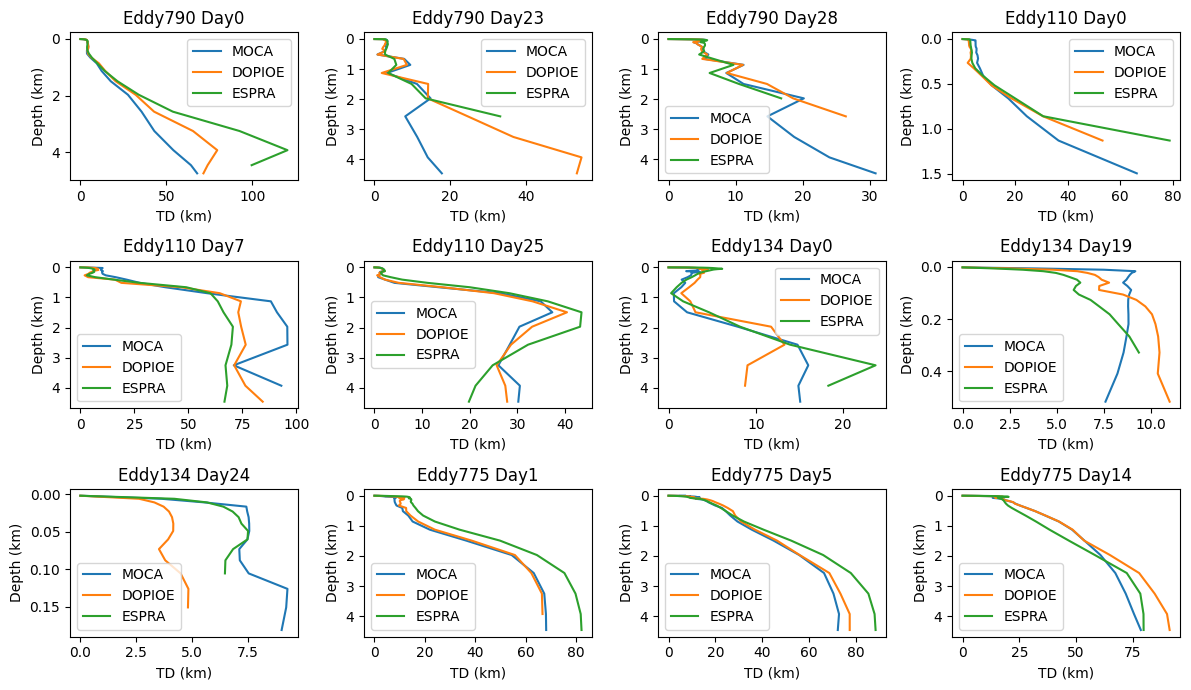

In [39]:
fig, axs = plt.subplots(3, 4, figsize=(12, 7))

k = 0
for e, eddy in enumerate(df_data1['Eddy'].unique()):
    for d, day in enumerate(df_data1['Day'].unique()):

        ax = axs[k // 4, k % 4]
        
        df_moc = df_data1[(df_data1['Eddy']==eddy)&(df_data1['Day']==day)&(df_data1['Method']=='MOCA')]
        df_dop = df_data1[(df_data1['Eddy']==eddy)&(df_data1['Day']==day)&(df_data1['Method']=='DOPIOE')]
        df_esp = df_data1[(df_data1['Eddy']==eddy)&(df_data1['Day']==day)&(df_data1['Method']=='ESPRA')]
        
        if len(df_moc) > 0:
            TD_moc = np.hypot(df_moc['xc']- df_moc[df_moc['z']==0].iloc[0]['xc'],
                              df_moc['yc']- df_moc[df_moc['z']==0].iloc[0]['yc'])
            ax.plot(TD_moc, df_moc['Depth']/1000, label='MOCA')
        if len(df_dop) > 0:
            TD_dop = np.hypot(df_dop['xc']- df_dop[df_dop['z']==0].iloc[0]['xc'],
                              df_dop['yc']- df_dop[df_dop['z']==0].iloc[0]['yc'])
            ax.plot(TD_dop, df_dop['Depth']/1000, label='DOPIOE')
        if len(df_esp) > 0: 
            TD_esp = np.hypot(df_esp['xc']- df_esp[df_esp['z']==0].iloc[0]['xc'],
                              df_esp['yc']- df_esp[df_esp['z']==0].iloc[0]['yc'])
            ax.plot(TD_esp, df_esp['Depth']/1000, label='ESPRA')

        if (len(df_moc) > 0) and (len(df_dop) > 0) and (len(df_esp) > 0):
            k += 1

        ax.set_title(f'{eddy} Day{day}')
for ax in axs.flat:
    ax.invert_yaxis()
    ax.legend()
    ax.set_xlabel('TD (km)')
    ax.set_ylabel('Depth (km)')

plt.tight_layout()
plt.show()


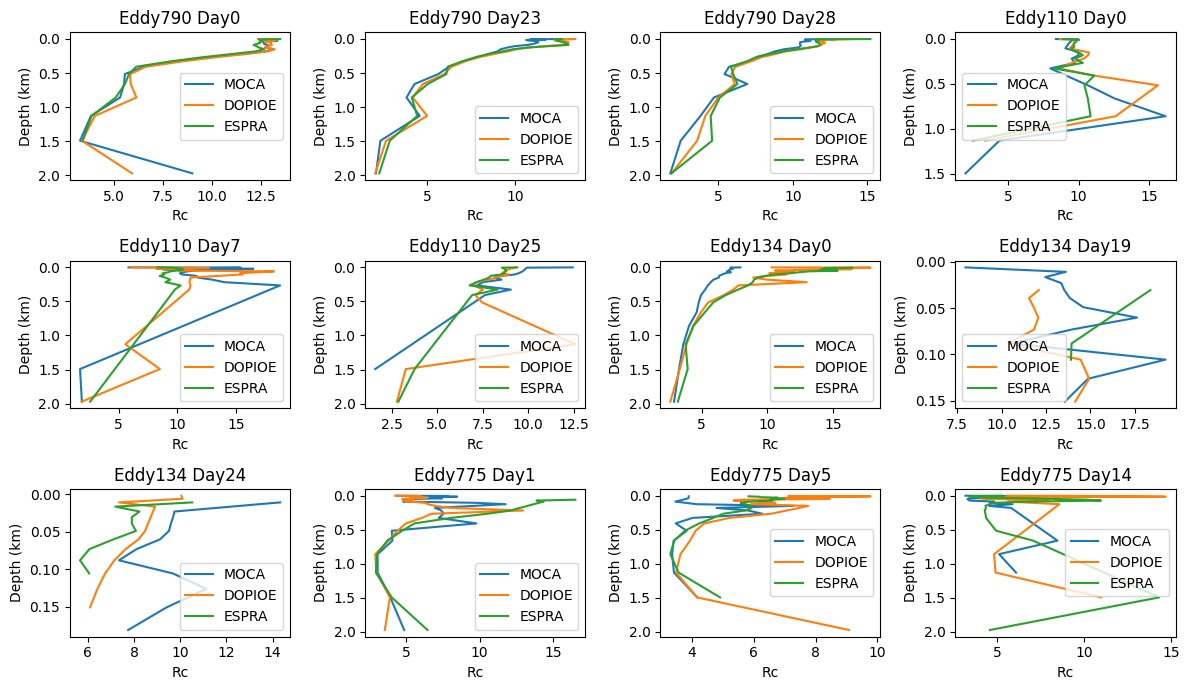

In [41]:
fig, axs = plt.subplots(3, 4, figsize=(12, 7))

k = 0
for e, eddy in enumerate(df_data1['Eddy'].unique()):
    for d, day in enumerate(df_data1['Day'].unique()):

        ax = axs[k // 4, k % 4]
        
        df_moc = df_data1[(df_data1['Eddy']==eddy)&(df_data1['Day']==day)&(df_data1['Method']=='MOCA')]
        df_dop = df_data1[(df_data1['Eddy']==eddy)&(df_data1['Day']==day)&(df_data1['Method']=='DOPIOE')]
        df_esp = df_data1[(df_data1['Eddy']==eddy)&(df_data1['Day']==day)&(df_data1['Method']=='ESPRA')]

        def remove_outlier_sign(df, col): # Remove odd psi values
            signs = np.sign(df[col])
            majority_sign = signs.value_counts().idxmax()
            return df[signs == majority_sign]
        
        if len(df_moc) > 0:

            df_moc = remove_outlier_sign(df_moc, 'psi0')

            mask = (df_moc['Depth'] <= 2500) & (df_moc['Rc'] <= 20)
            ax.plot(df_moc['Rc'][mask], df_moc['Depth'][mask]/1000, label='MOCA')
        if len(df_dop) > 0:

            df_dop = remove_outlier_sign(df_dop, 'psi0')
            
            mask = (df_dop['Depth'] <= 2500) & (df_dop['Rc'] <= 20)
            ax.plot(df_dop['Rc'][mask], df_dop['Depth'][mask]/1000, label='DOPIOE')
        if len(df_esp) > 0: 

            df_esp = remove_outlier_sign(df_esp, 'psi0')
            
            mask = (df_esp['Depth'] <= 2500) & (df_esp['Rc'] <= 20)
            ax.plot(df_esp['Rc'][mask], df_esp['Depth'][mask]/1000, label='ESPRA')

        if (len(df_moc) > 0) and (len(df_dop) > 0) and (len(df_esp) > 0):
            k += 1

        ax.set_title(f'{eddy} Day{day}')
for ax in axs.flat:
    ax.invert_yaxis()
    ax.legend()
    ax.set_xlabel('Rc')
    ax.set_ylabel('Depth (km)')

plt.tight_layout()
plt.show()


In [15]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

#### 3D Restructuring

In [42]:
df_3D = df_data1.merge(df_plot[['Eddy', 'Day']], on=['Eddy', 'Day'], how='inner')
df_3D = df_3D[(df_3D['Depth'] < 2500) & (df_3D['Rc'] <= 20)]
df_3D


,Eddy,Day,Method,xc,yc,w,Q,Rc,psi0,z,Depth
0,Eddy790,0,MOCA,7.073857,-0.320018,0.040862,"[[0.01021553889105897, 0.0], [0.0, 0.010215538...",12.724221,-162.681615,0,1.783320
1,Eddy790,0,DOPIOE,6.978846,-0.998736,0.037260,"[[0.010215538891058966, -0.0009718163712696494...",12.352301,-153.567700,0,1.783320
2,Eddy790,0,ESPRA,6.908389,1.146804,0.033621,"[[0.009175594081254197, -0.0010552806033315128...",13.480621,-190.007127,0,1.783320
3,Eddy790,0,MOCA,6.200574,0.440724,0.041154,"[[0.010288600328302724, 0.0], [0.0, 0.01028860...",12.657973,-160.213307,1,5.879627
4,Eddy790,0,DOPIOE,6.288312,0.726667,0.037228,"[[0.010268912104250244, -0.0009866409949699693...",12.828645,-164.809556,1,5.879627
...,...,...,...,...,...,...,...,...,...,...,...
923,Eddy775,14,DOPIOE,-41.952894,33.374164,-0.004725,"[[-0.0014697790862164214, 0.000211999846880574...",10.997459,121.020041,23,1492.971178
924,Eddy775,14,ESPRA,-45.767125,31.458398,-0.004643,"[[-0.0014322821126909447, 0.000192028394107694...",14.329052,-204.134383,23,1492.971178
925,Eddy775,14,MOCA,-47.979387,37.567232,-0.005814,"[[-0.0014535931373946558, 0.0], [0.0, -0.00145...",3.927797,-14.860038,24,1971.212518
926,Eddy775,14,DOPIOE,-45.026420,47.068082,-0.004437,"[[-0.00149969515436713, 0.0001520439053659577]...",4.446892,-19.027711,24,1971.212518


In [45]:
def interpolate_to_regular_grid(X, Y, U, V, z, dx, method='linear'):
    from scipy.interpolate import RegularGridInterpolator
    x = X[:, 0]
    y = Y[0, :]
    new_x = np.arange(x.min(), x.max(), dx)
    new_y = np.arange(y.min(), y.max(), dx)
    new_z = np.linspace(z.min(), z.max(), len(z))
    rgi_u = RegularGridInterpolator((x, y, z), U, method=method, bounds_error=False, fill_value=np.nan)
    rgi_v = RegularGridInterpolator((x, y, z), V, method=method, bounds_error=False, fill_value=np.nan)
    xx, yy, zz = np.meshgrid(new_x, new_y, new_z, indexing='ij')
    pts = np.stack((xx, yy, zz), axis=-1)
    Un = rgi_u(pts)
    Vn = rgi_v(pts)
    Xn, Yn = np.meshgrid(new_x, new_y, indexing='ij')
    return Xn, Yn, new_z, Un, Vn
    

In [65]:
def plot_isosurface(ax, Xn, Yn, zn, Un, Vn, level=-0.2, elev=13, azim=135):
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    from skimage.measure import marching_cubes
    from scipy.ndimage import map_coordinates
    ow = calc_ow(Un, Vn, dx*1000, dx*1000, flag=False)
    sigma_ow = normalize_matrix(ow)

    Xg, Yg, Zg = np.meshgrid(Xn[:, 0], Yn[0, :], zn/1000, indexing='ij')

    verts, faces, normals, values = marching_cubes(sigma_ow, level=level)
    pts = verts.T
    real_x = map_coordinates(Xg, pts, order=1)
    real_y = map_coordinates(Yg, pts, order=1)
    real_z = map_coordinates(Zg, pts, order=1)
    real_verts = np.vstack((real_x, real_y, real_z)).T

    mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    ax.set_xlim(Xg.min(), Xg.max())
    ax.set_ylim(Yg.min(), Yg.max())
    ax.set_zlim(Zg.min(), Zg.max())
    ax.invert_zaxis()
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_zlabel('Depth (km)')
    ax.view_init(elev=elev, azim=azim)
    

#### Generalise

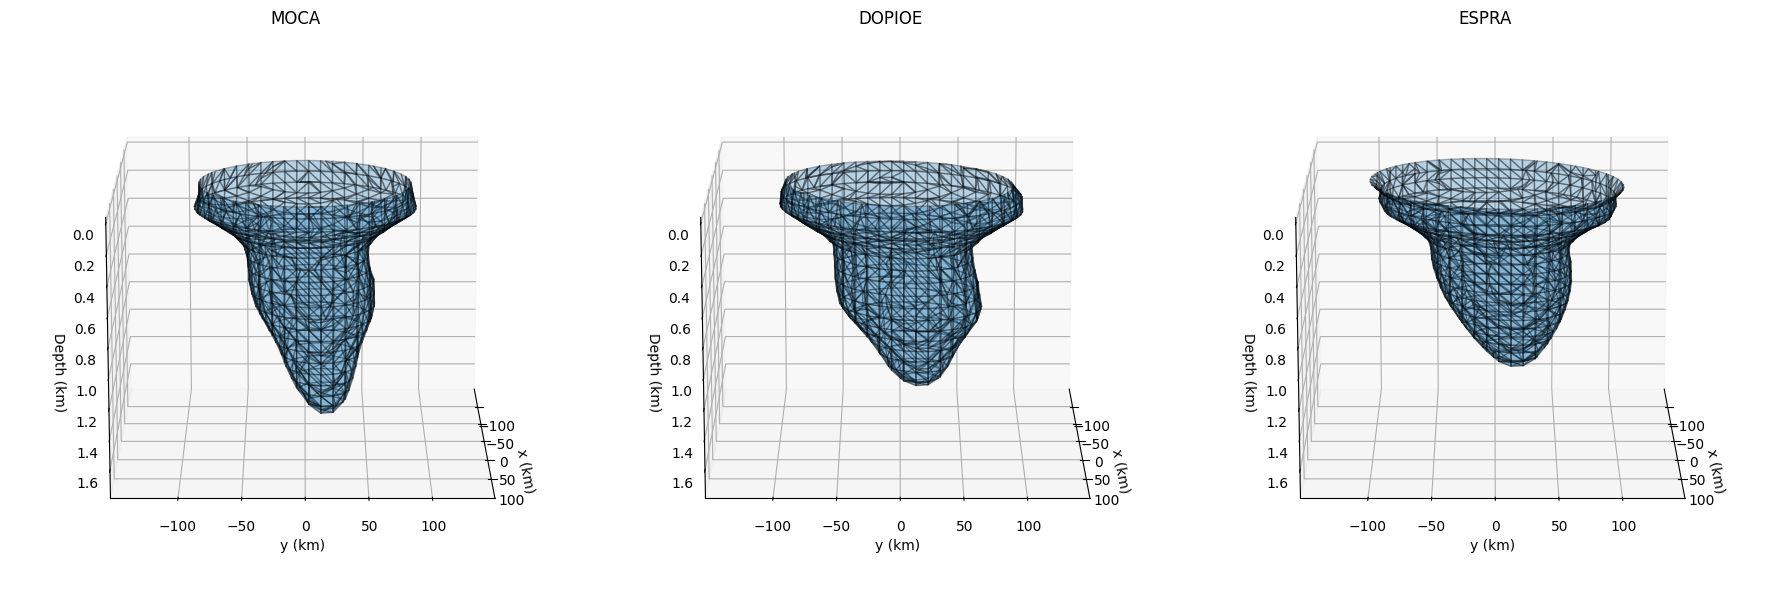

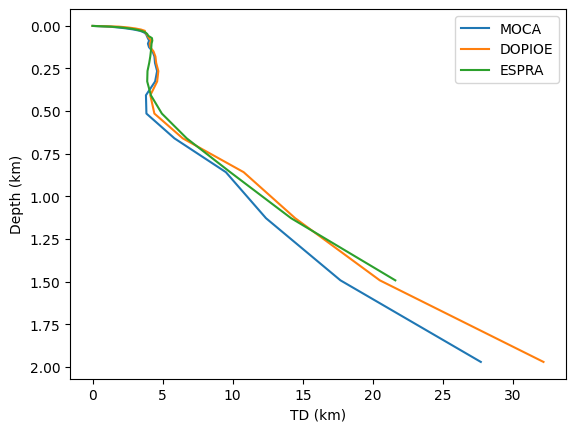

In [87]:
# eddy = 'Eddy134'
# day = 0

eddy = 'Eddy790'
day = 0

dic = sample_data[eddy][f'T{day}']
U, V, x, y, z = dic['U'], dic['V'], dic['x']/1000, dic['y']/1000, -dic['z']/1000
X, Y = np.meshgrid(x, y, indexing='ij')

df_moc = df_3D[(df_3D['Eddy']==eddy)&(df_3D['Day']==day)&(df_3D['Method']=='MOCA')]
df_dop = df_3D[(df_3D['Eddy']==eddy)&(df_3D['Day']==day)&(df_3D['Method']=='DOPIOE')]
df_esp = df_3D[(df_3D['Eddy']==eddy)&(df_3D['Day']==day)&(df_3D['Method']=='ESPRA')]

def remove_outlier_sign(df, col): # Remove odd psi values
    signs = np.sign(df[col])
    majority_sign = signs.value_counts().idxmax()
    return df[signs == majority_sign]

df_moc = remove_outlier_sign(df_moc, 'psi0')
df_dop = remove_outlier_sign(df_dop, 'psi0')
df_esp = remove_outlier_sign(df_esp, 'psi0')

U_moc, V_moc = np.zeros((X.shape[0], X.shape[1], len(df_moc))), np.zeros((X.shape[0], X.shape[1], len(df_moc)))
for kk, k in enumerate(df_moc['z'].unique()):
    row_moc = df_moc[df_moc['z'] == k].iloc[0]
    x0_moc, y0_moc, Q_moc, Rc_moc, psi0_moc = row_moc['xc'], row_moc['yc'], row_moc['Q'], row_moc['Rc'], row_moc['psi0']
    u_moc, v_moc, X_moc, Y_moc = gaussian_vel_reconstruction(x0_moc, y0_moc, Q_moc[0,0], Q_moc[1,0], Q_moc[1,1], Rc_moc, psi0_moc, X, Y)
    U_moc[:,:,kk] = u_moc
    V_moc[:,:,kk] = v_moc
U_dop, V_dop = np.zeros((X.shape[0], X.shape[1], len(df_dop))), np.zeros((X.shape[0], X.shape[1], len(df_dop)))
for kk, k in enumerate(df_dop['z'].unique()):
    row_dop = df_dop[df_dop['z'] == k].iloc[0]
    x0_dop, y0_dop, Q_dop, Rc_dop, psi0_dop = row_dop['xc'], row_dop['yc'], row_dop['Q'], row_dop['Rc'], row_dop['psi0']
    u_dop, v_dop, X_dop, Y_dop = gaussian_vel_reconstruction(x0_dop, y0_dop, Q_dop[0,0], Q_dop[1,0], Q_dop[1,1], Rc_dop, psi0_dop, X, Y)
    U_dop[:,:,kk] = u_dop
    V_dop[:,:,kk] = v_dop
V_esp, U_esp= np.zeros((X.shape[0], X.shape[1], len(df_esp))), np.zeros((X.shape[0], X.shape[1], len(df_esp)))
for kk, k in enumerate(df_esp['z'].unique()):
    row_esp = df_esp[df_esp['z'] == k].iloc[0]
    x0_esp, y0_esp, Q_esp, Rc_esp, psi0_esp = row_esp['xc'], row_esp['yc'], row_esp['Q'], row_esp['Rc'], row_esp['psi0']
    u_esp, v_esp, X_esp, Y_esp = gaussian_vel_reconstruction(x0_esp, y0_esp, Q_esp[0,0], Q_esp[1,0], Q_esp[1,1], Rc_esp, psi0_esp, X, Y)
    U_esp[:,:,kk] = u_esp
    V_esp[:,:,kk] = v_esp

dx = 10.0
Xn_moc, Yn_moc, zn_moc, Un_moc, Vn_moc = interpolate_to_regular_grid(X_moc, Y_moc, U_moc, V_moc, df_moc['Depth'].values, dx=dx)
Xn_dop, Yn_dop, zn_dop, Un_dop, Vn_dop = interpolate_to_regular_grid(X_dop, Y_dop, U_dop, V_dop, df_dop['Depth'].values, dx=dx)
Xn_esp, Yn_esp, zn_esp, Un_esp, Vn_esp = interpolate_to_regular_grid(X_esp, Y_esp, U_esp, V_esp, df_esp['Depth'].values, dx=dx)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

azim, elev = 0, 15
z_btm = 1.75
plot_isosurface(axs[0], Xn_moc, Yn_moc, zn_moc, Un_moc, Vn_moc, elev=elev, azim=azim)
axs[0].set_title('MOCA'); axs[0].set_zlim(z_btm, 0)
plot_isosurface(axs[1], Xn_dop, Yn_dop, zn_dop, Un_dop, Vn_dop, elev=elev, azim=azim)
axs[1].set_title('DOPIOE'); axs[1].set_zlim(z_btm, 0)
plot_isosurface(axs[2], Xn_esp, Yn_esp, zn_esp, Un_esp, Vn_esp, elev=elev, azim=azim)
axs[2].set_title('ESPRA'); axs[2].set_zlim(z_btm, 0)
plt.tight_layout()
plt.show()

TD_moc = np.hypot(df_moc['xc']- df_moc[df_moc['z']==0].iloc[0]['xc'], df_moc['yc']- df_moc[df_moc['z']==0].iloc[0]['yc'])
TD_dop = np.hypot(df_dop['xc']- df_dop[df_dop['z']==0].iloc[0]['xc'], df_dop['yc']- df_dop[df_dop['z']==0].iloc[0]['yc'])
TD_esp = np.hypot(df_esp['xc']- df_esp[df_esp['z']==0].iloc[0]['xc'], df_esp['yc']- df_esp[df_esp['z']==0].iloc[0]['yc'])
plt.plot(TD_moc, df_moc['Depth']/1000, label='MOCA'); axs[0].invert_yaxis(); axs[0].set_xlabel('TD (km)')
plt.plot(TD_dop, df_dop['Depth']/1000, label='DOPIOE'); axs[1].invert_yaxis(); axs[1].set_xlabel('TD (km)')
plt.plot(TD_esp, df_esp['Depth']/1000, label='ESPRA'); axs[2].invert_yaxis(); axs[2].set_xlabel('TD (km)')
plt.gca().invert_yaxis(); plt.ylabel('Depth (km)'); plt.xlabel('TD (km)'); plt.legend()


In [67]:
W_moc = solve_w(Un_moc, Vn_moc, Xn_moc[:,0], Yn_moc[0,:], zn_moc)
W_dop = solve_w(Un_dop, Vn_dop, Xn_dop[:,0], Yn_dop[0,:], zn_dop)
W_esp = solve_w(Un_esp, Vn_esp, Xn_esp[:,0], Yn_esp[0,:], zn_esp)


In [61]:
def W_plotter(Xn, Yn, zn, W, method, eddy, day):
    rows, cols = 6, 5
    fig, axs = plt.subplots(rows, cols, figsize=(15, 12))
    fig.suptitle(f'{method} - {eddy} - Day{day}')
    for p in range(W.shape[-1]):
        ax = axs[p // cols, p % cols]
        cf = ax.contourf(Xn[:,0], Yn[0,:], W[:, :, p] * 86400 )
        ax.axis('equal')
        ax.set_title(f'Depth {round(zn[p])}m')
        fig.colorbar(cf, ax=ax, label=r'm Day$^{-1}$')
    plt.tight_layout()
    plt.show()
    

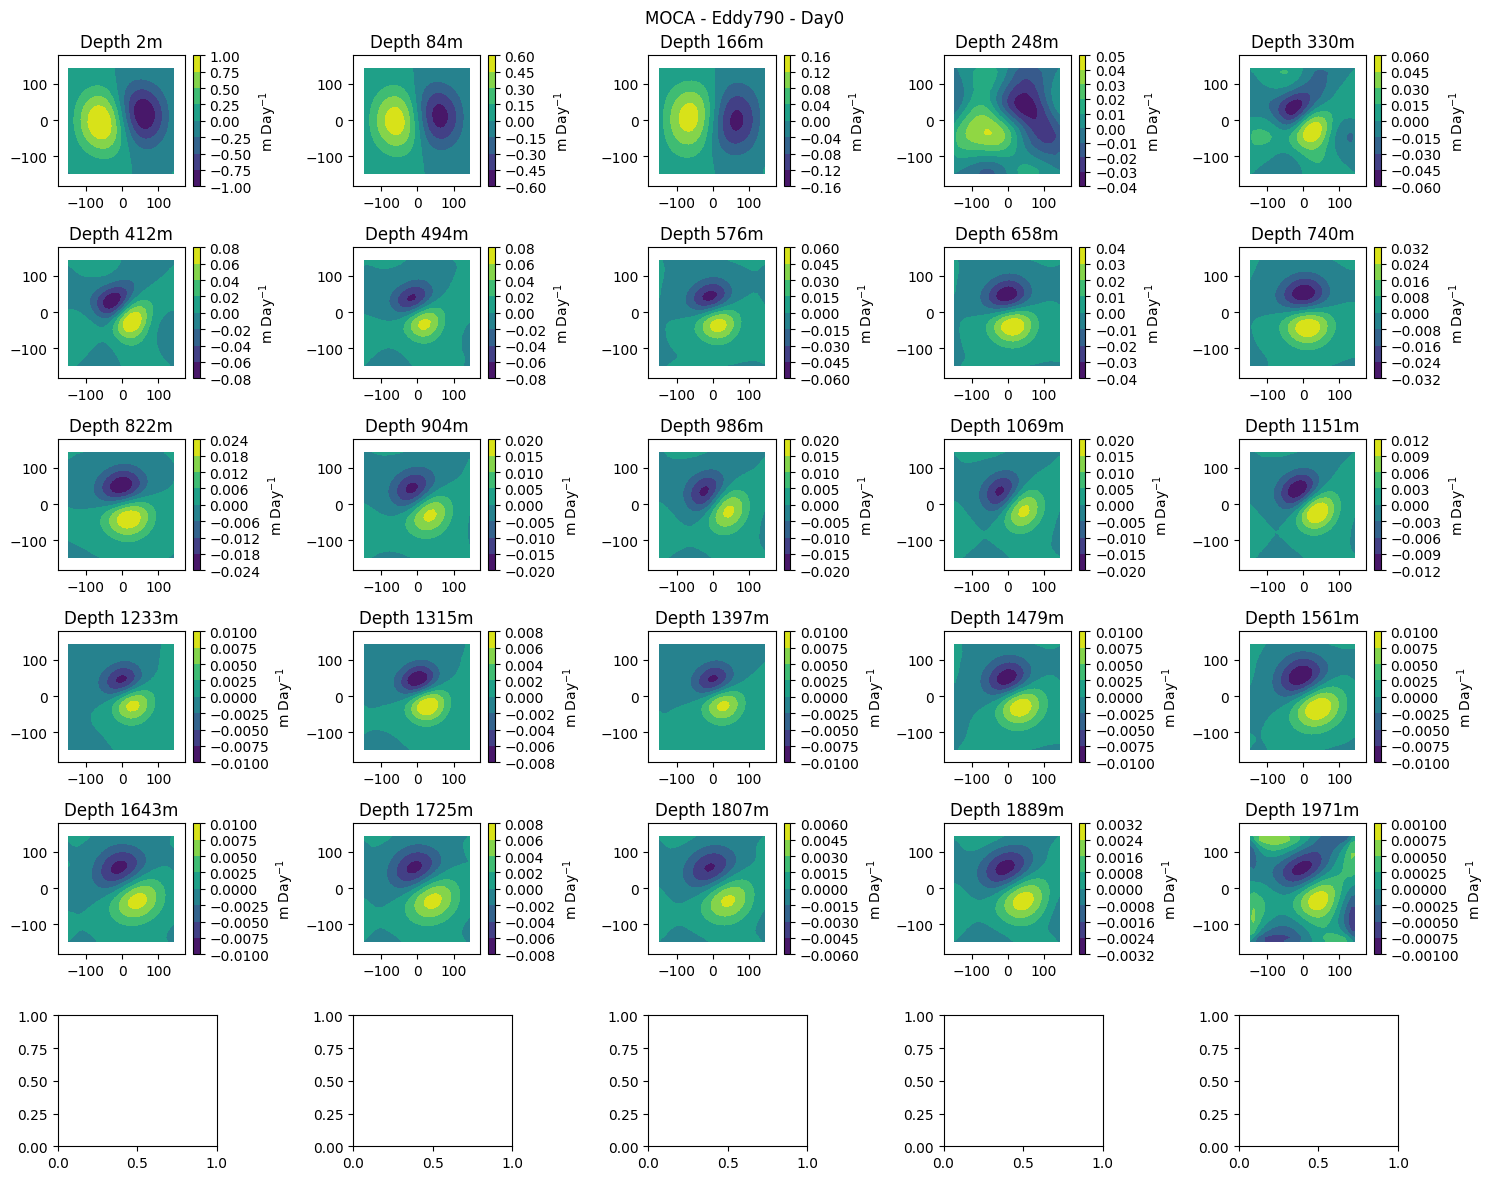

In [62]:
W_plotter(Xn_moc, Yn_moc, zn_moc, W_moc, 'MOCA', eddy, day)

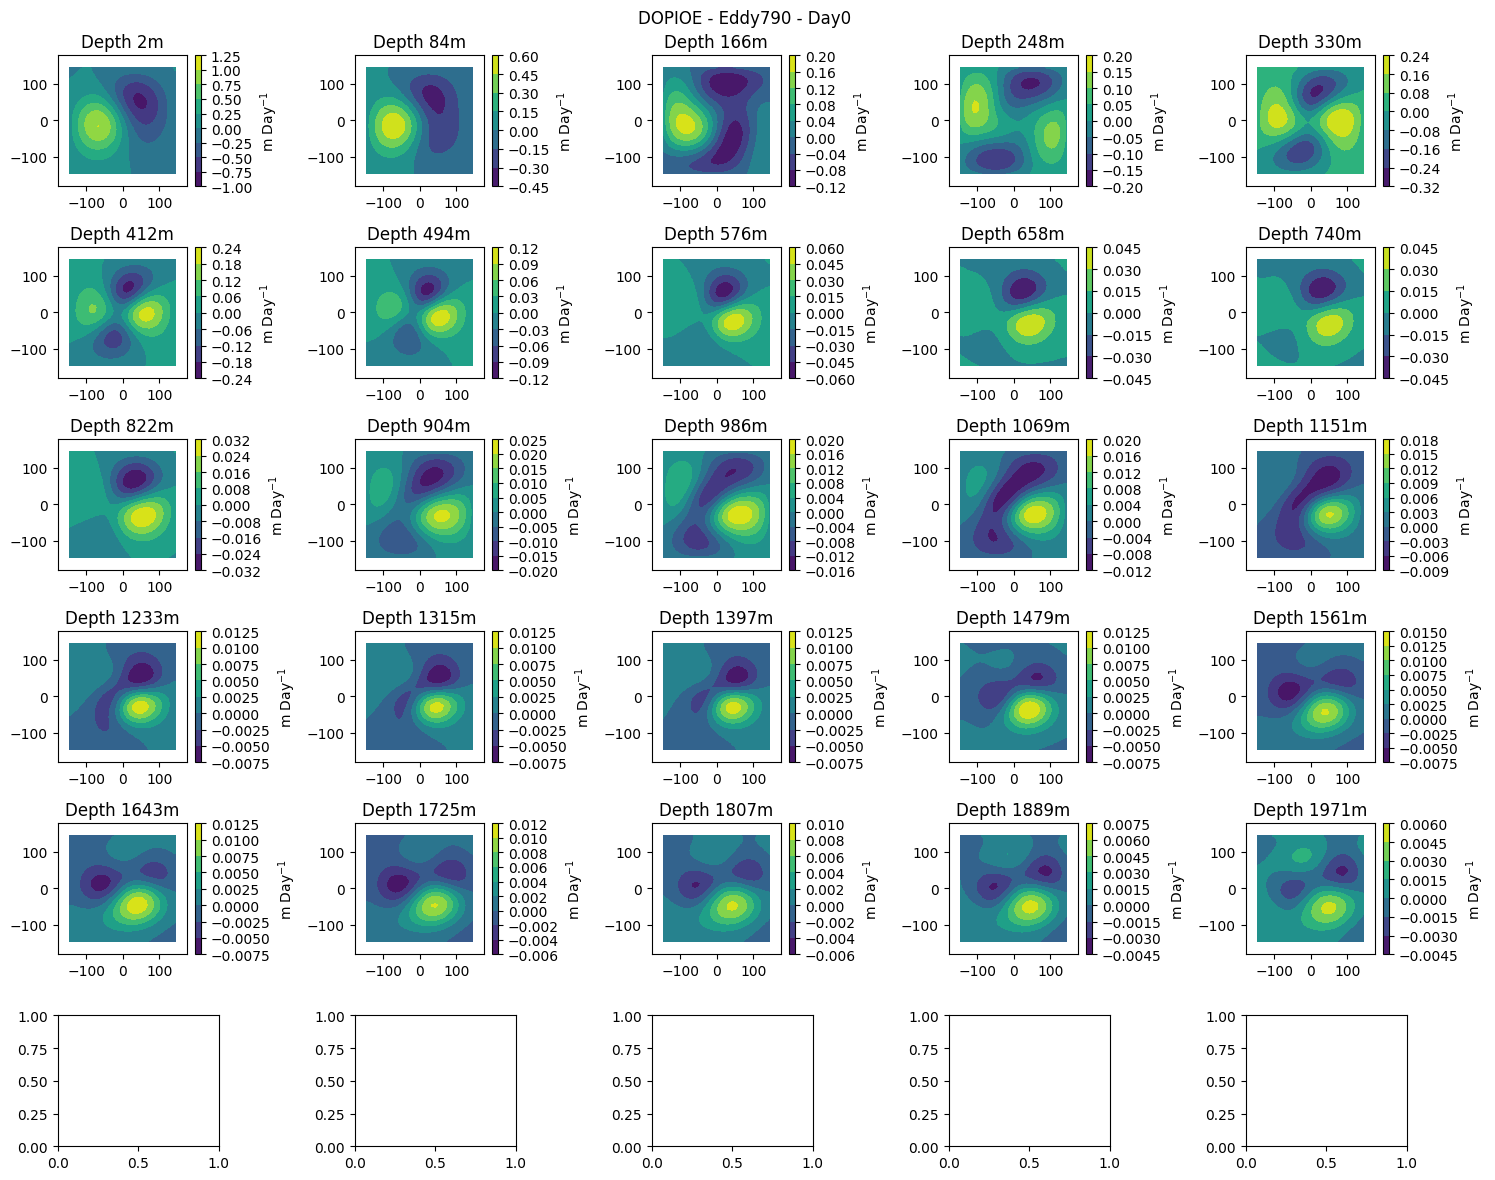

In [63]:
W_plotter(Xn_dop, Yn_dop, zn_dop, W_dop, 'DOPIOE', eddy, day)

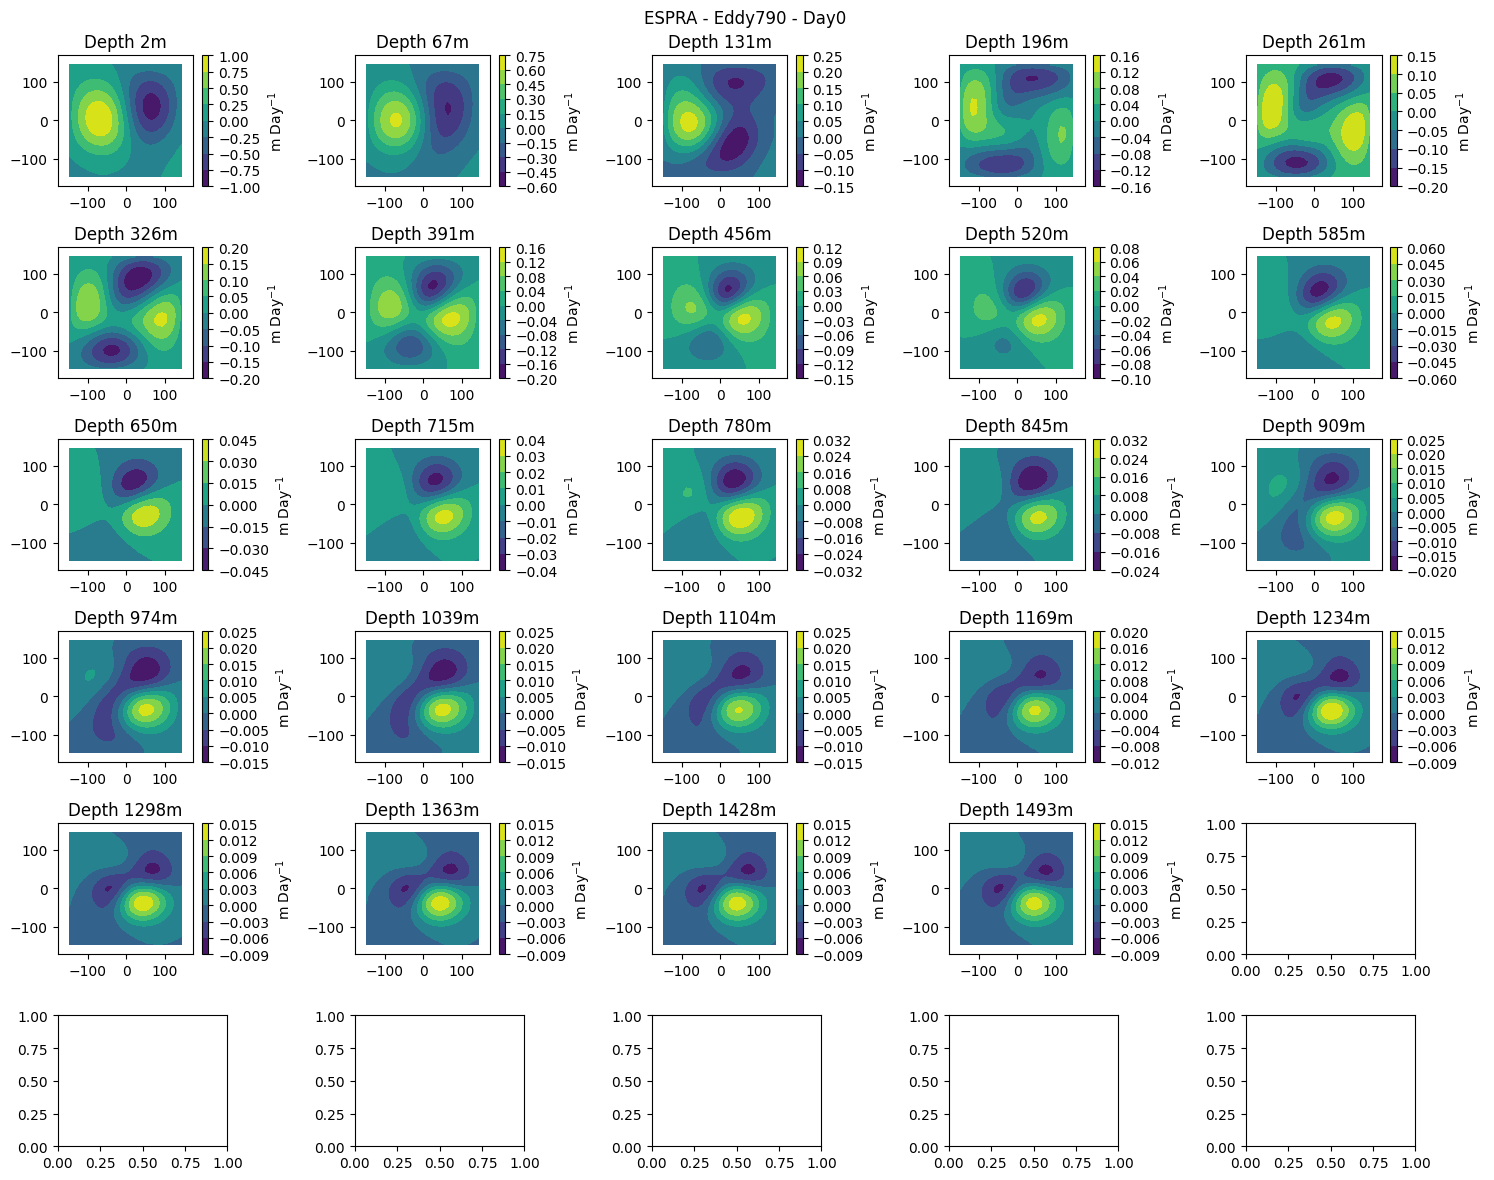

In [64]:
W_plotter(Xn_esp, Yn_esp, zn_esp, W_esp, 'ESPRA', eddy, day)